<a href="https://colab.research.google.com/github/SJP0308/MLTUTORIAL/blob/House-Prices/House_Prices3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Define Problem**

**It is your job to predict the sales price for each house.** For each Id in the test set, you must predict the value of the SalePrice variable.

# **Evaluation**

**Submissions are evaluated on Root-Mean-Squared-Error (RMSE)** between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# **Download**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# 경고 메시지를 무시하도록 설정
warnings.filterwarnings('ignore')

# 플롯을 인라인으로 표시하도록 설정
%matplotlib inline

In [2]:
# 데이터셋 다운로드
def download_dataset(datafile_name):
  from google.colab import drive
  drive.mount('/content/drive')
  path = f'/content/drive/My Drive/{datafile_name}'
  train_df = pd.read_csv(f'{path}/train.csv')
  test_df = pd.read_csv(f'{path}/test.csv')
  print('데이터 다운로드 완료!')
  return pd.concat([train_df, test_df], ignore_index=True)

In [3]:
df = download_dataset('house_prices')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 다운로드 완료!


# **Features**

In [4]:
# groupby로 결측치 채우기
def fill_null_by_group(df, group_col, target_col):
  return df[target_col].fillna(df.groupby(group_col)[target_col].transform(lambda x: x.mode()[0] if not x.mode().empty
                                                                           else df[target_col].mode()[0]))

In [5]:
for col in ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']:
            df[col] = df[col].fillna('None')

for col in ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
  df[col] = df[col].fillna(0)

groupby = {'Neighborhood': ['MSZoning', 'LotFrontage', 'Exterior1st', 'Exterior2nd', 'Electrical'],
           'KitchenAbvGr': ['KitchenQual'],
           'GarageType': ['GarageYrBlt', 'GarageCars', 'GarageArea']}
for key, group in groupby.items():
  for col in group:
    df[col] = fill_null_by_group(df, key, col)

df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df["Functional"] = df["Functional"].fillna("Typ")
df.drop(['Id'], axis=1, inplace=True)
df.drop(['Utilities'], axis=1, inplace=True)

for col in ['MSSubClass', 'YrSold', 'MoSold']:
  df[col] = df[col].apply(str)

In [6]:
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<2.60)].index)
df.reset_index(drop=True, inplace=True)
df['SalePrice'] = np.log1p(df.SalePrice)

# **Data processing**

In [7]:
# 스피어맨 인코딩
def Spearman_encode(df, feature):
    ordering = df.groupby(feature)['SalePrice'].mean().sort_values().reset_index()
    ordering['ordering'] = range(1, len(ordering)+1)
    df[feature] = df[feature].map(dict(zip(ordering[feature], ordering['ordering'])))
    return df

In [8]:
qualitative = df.select_dtypes(include='object')

for col in qualitative:
  df = Spearman_encode(df, col)

In [9]:
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

quantitative = df.select_dtypes(include='number').columns[:-1]
high_skew = quantitative[df[quantitative].apply(lambda x: skew(x)) > 0.5]
for col in high_skew:
    try:
        df[col] = boxcox1p(df[col], boxcox_normmax(df[col]+1))
    except:
        df[col] = np.log1p(df[col])

In [10]:
df['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Total_sqr_footage'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Total_Bathrooms'] = df['FullBath'] + (0.5*df['HalfBath']) + df['BsmtFullBath'] + (0.5*df['BsmtHalfBath'])
df['Total_porch_sf'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

df = pd.get_dummies(df).reset_index(drop=True)

In [11]:
from sklearn.preprocessing import RobustScaler

rbst_scaler=RobustScaler()
X_train = rbst_scaler.fit_transform(df[df['SalePrice'].notnull()].drop('SalePrice', axis=1).values)
X_test = rbst_scaler.transform(df[df['SalePrice'].isnull()].drop('SalePrice', axis=1).values)
target_label = df[df['SalePrice'].notnull()]['SalePrice'].values

# **Model**

```
pip install -q optuna
```

```
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    
    cv_scores = []  
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]  
        y_train, y_val = y[train_idx], y[val_idx]  
        
        model = GradientBoostingRegressor(**param, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        cv_scores.append(rmse)

    return np.mean(cv_scores)

study = optuna.create_study(study_name='GradientBoostingRegressor_KFold', direction='minimize', sampler=TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, X_train, target_label), n_trials=100)

print()
print("Best Score (RMSE):", study.best_value)
print("Best trial:", study.best_trial.params)
```

Best Score (RMSE): 0.12405450783607379

Best trial: {'n_estimators': 357, 'max_depth': 3, 'learning_rate': 0.058789251728333054, 'subsample': 0.7672132168417385, 'min_samples_split': 4, 'min_samples_leaf': 3}

```
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler

cv = KFold(n_splits=5, shuffle=True, random_state=84)

def objective(trial, X, y):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',  
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }
    
    cv_scores = []  
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]  
        y_train, y_val = y[train_idx], y[val_idx]  
        
        model = XGBRegressor(**param, random_state=84)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        cv_scores.append(rmse)

    return np.mean(cv_scores)

study = optuna.create_study(study_name='XGBRegressor_KFold', direction='minimize', sampler=TPESampler(seed=84))
study.optimize(lambda trial: objective(trial, X_train, target_label), n_trials=100)

print()
print("Best Score (RMSE):", study.best_value)
print("Best trial:", study.best_trial.params)
```

Best Score (RMSE): 0.12356110332037154

Best trial: {'n_estimators': 416, 'max_depth': 6, 'learning_rate': 0.033282432310440334, 'subsample': 0.8254858262956372, 'colsample_bytree': 0.9157884273317746, 'gamma': 0.001668907747602897}

```
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler

cv = KFold(n_splits=5, shuffle=True, random_state=126)

def objective(trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20)
    }
    
    cv_scores = []  
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]  
        y_train, y_val = y[train_idx], y[val_idx]  
        
        model = LGBMRegressor(**param, verbosity=-1, random_state=126)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        cv_scores.append(rmse)

    return np.mean(cv_scores)

study = optuna.create_study(study_name='LGBMRegressor_KFold', direction='minimize', sampler=TPESampler(seed=126))
study.optimize(lambda trial: objective(trial, X_train, target_label), n_trials=100)

print()
print("Best Score (RMSE):", study.best_value)
print("Best trial:", study.best_trial.params)
```

Best Score (RMSE): 0.11877221440508838

Best trial: {'n_estimators': 476, 'max_depth': 3, 'learning_rate': 0.08575242754533631, 'subsample': 0.5828043279150275, 'colsample_bytree': 0.8264573049966885, 'min_child_samples': 3}

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

gbr_param = {'n_estimators': 357, 'max_depth': 3, 'learning_rate': 0.058789251728333054, 'subsample': 0.7672132168417385,
             'min_samples_split': 4, 'min_samples_leaf': 3}
xgb_param = {'n_estimators': 416, 'max_depth': 6, 'learning_rate': 0.033282432310440334, 'subsample': 0.8254858262956372,
             'colsample_bytree': 0.9157884273317746, 'gamma': 0.001668907747602897}
lgb_param = {'n_estimators': 476, 'max_depth': 3, 'learning_rate': 0.08575242754533631, 'subsample': 0.5828043279150275,
             'colsample_bytree': 0.8264573049966885, 'min_child_samples': 3}

GBR = GradientBoostingRegressor(**gbr_param, random_state=42).fit(X_train, target_label)
XGB = XGBRegressor(**xgb_param, random_state=84).fit(X_train, target_label)
LGB = LGBMRegressor(**lgb_param, verbose=-1, random_state=126).fit(X_train, target_label)

# **Ensemble**

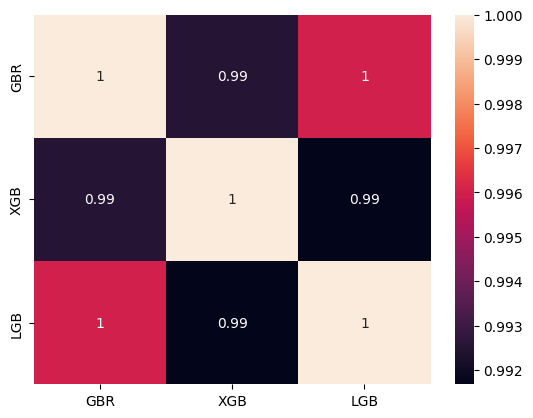

In [13]:
test_GBR = pd.Series(GBR.predict(X_test), name="GBR")
test_XGB = pd.Series(XGB.predict(X_test), name="XGB")
test_LGB = pd.Series(LGB.predict(X_test), name="LGB")

ensemble_results = pd.concat([test_GBR, test_XGB, test_LGB],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

In [14]:
ensemble = np.expm1(0.3*test_GBR + 0.3*test_XGB + 0.4*test_LGB)
submission = pd.read_csv('/content/drive/My Drive/house_prices/sample_submission.csv')
submission['SalePrice'] = ensemble
submission.to_csv('./ensemble_answer.csv', index=False)

In [15]:
from sklearn.ensemble import VotingRegressor

votingC = VotingRegressor(estimators=[('GBR',GBR), ('XGB', XGB), ('LGB', LGB)], n_jobs=-1)
votingC = votingC.fit(X_train, target_label)
vote = pd.Series(votingC.predict(X_test))
submission = pd.read_csv('/content/drive/My Drive/house_prices/sample_submission.csv')
submission['SalePrice'] = vote
submission.to_csv('./vote_answer.csv', index=False)

In [16]:
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

clf1 = GBR
clf2 = XGB
clf3 = LGB

sr =  StackingRegressor(regressors=[clf1, clf2, clf3], meta_regressor=RandomForestRegressor())
stacking = sr.fit(X_train, target_label)
stack = stacking.predict(X_test)

submission = pd.read_csv('/content/drive/My Drive/house_prices/sample_submission.csv')
submission['SalePrice'] = stack
submission.to_csv('./stack_answer.csv', index=False)

In [17]:
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_enect = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
enect_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_ridge, cv=kfolds))
lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=10000000, alphas=alphas_lasso,
                              random_state=2, cv=kfolds))
enet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=10000000, alphas=alphas_enect,
                                        cv=kfolds, l1_ratio=enect_l1ratio))
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, enet,
                                            GBR, XGB, LGB),
                                meta_regressor=XGB,
                                use_features_in_secondary=True)

stack_gen_model = stack_gen.fit(np.array(X_train), np.array(target_label))
elastic_model = enet.fit(X_train, target_label)
lasso_model = lasso.fit(X_train, target_label)
ridge_model = ridge.fit(X_train, target_label)
svr_model = svr.fit(X_train, target_label)
gbr_model = GBR.fit(X_train, target_label)
xgb_model = XGB.fit(X_train, target_label)
lgb_model = LGB.fit(X_train, target_label)

def blend_models_predict(X):
    return ((0.1 * elastic_model.predict(X)) + \
            (0.1 * lasso_model.predict(X)) + \
            (0.1 * ridge_model.predict(X)) + \
            (0.1 * svr_model.predict(X)) + \
            (0.1 * gbr_model.predict(X)) + \
            (0.15 * xgb_model.predict(X)) + \
            (0.1 * lgb_model.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))

blend = np.floor(np.expm1(blend_models_predict(X_test)))
submission = pd.read_csv('/content/drive/My Drive/house_prices/sample_submission.csv')
submission['SalePrice'] = blend
submission.to_csv('./blend_answer.csv', index=False)